In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

import cometToolkit as comets
import cometToolkit as ctk

from astropy.nddata import Cutout2D

### Comet Stacking

##### Basic Plotting

#### Finding the optocentre

In [2]:
import cometToolkit as ctk
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from natsort import natsorted
from glob import glob

from astropy.nddata import Cutout2D

from astropy.stats import sigma_clipped_stats

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from tqdm import tqdm

#### Visualising Stack

In [3]:
day = "Day12"

match day:
    case "Day12":
        wcs = WCS(fits.open("../../Data/wcs/day12.fits")[0].header)
        dayInt = 0

        roughPos=(980, 980)
        cropOffset=[+200, 0]

        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

    case "Day13":
        wcs = WCS(fits.open("../../Data/wcs/day13.fits")[0].header)
        dayInt = 1

        roughPos=(760, 1000)
        cropOffset=[+200, 0]

        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-4]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-5]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-6]

    case "Day14":
        wcs = WCS(fits.open("../../Data/wcs/day14.fits")[0].header)
        dayInt = 2

        roughPos=(500, 1000)
        cropOffset=[+300, 0]

        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

    case "Day17":
        wcs = WCS(fits.open("../../Data/wcs/day17.fits")[0].header)
        dayInt = 3

        roughPos=(650, 1000)
        cropOffset=[+200, 0]

        # Note: Excluding last few images due to cloud
        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-3]

print(vReducedDataPaths)
print(rReducedDataPaths)
print(bReducedDataPaths)

['../../Python/DataProducts/ReducedImages/Day12/V/Comet62P_V00.fits', '../../Python/DataProducts/ReducedImages/Day12/V/Comet62P_V01.fits', '../../Python/DataProducts/ReducedImages/Day12/V/Comet62P_V02.fits', '../../Python/DataProducts/ReducedImages/Day12/V/Comet62P_V03.fits', '../../Python/DataProducts/ReducedImages/Day12/V/Comet62P_V04.fits', '../../Python/DataProducts/ReducedImages/Day12/V/Comet62P_V05.fits', '../../Python/DataProducts/ReducedImages/Day12/V/Comet62P_V06.fits']
['../../Python/DataProducts/ReducedImages/Day12/R/Comet62P_R00.fits', '../../Python/DataProducts/ReducedImages/Day12/R/Comet62P_R01.fits', '../../Python/DataProducts/ReducedImages/Day12/R/Comet62P_R02.fits', '../../Python/DataProducts/ReducedImages/Day12/R/Comet62P_R03.fits', '../../Python/DataProducts/ReducedImages/Day12/R/Comet62P_R04.fits', '../../Python/DataProducts/ReducedImages/Day12/R/Comet62P_R05.fits', '../../Python/DataProducts/ReducedImages/Day12/R/Comet62P_R06.fits']
['../../Python/DataProducts/Redu

In [30]:
def StackImages(paths, filter, day, roughPosition, size, offset, removeStars=True):
    stackingImages = []

    cutouts = []

    for p, path in enumerate(paths):
        image = fits.open(path)[0].data

        centre = ctk.FindCometCentre(path, filter, day, method="starfinder", roughPosition=roughPosition, maxCentreDistance=50, showPlot=True, useBackground=False)

        mean, median, std = sigma_clipped_stats(image, sigma=5.0)
        background = median

        image = image - background

        # Here: need to Replace stars with surrounding background
        if removeStars:

            sources = ctk.SearchStars(image + background, fwhm=3, threshold=5*std, showPlot=False)

            cometPositionTolerance = 10
            starPositions = []

            for i, s in enumerate(sources):
                if (s["xcentroid"] - centre[0])**2 < cometPositionTolerance and (s["ycentroid"] - centre[1])**2 < cometPositionTolerance:
                    # this is the comet, continue
                    sources.remove_row(i)
                else:
                    continue
            
            # Consider sorting this list to start with further from the comet and work inwards
            starPositions = np.transpose((sources["xcentroid"], sources["ycentroid"]))
            
            apRadius=10 / 0.6 # arcsec to pixels
            inner=12 / 0.6
            outer=18 / 0.6

            circApertures = CircularAperture(starPositions, r=apRadius)
            annulusApertures = CircularAnnulus(starPositions, r_in=inner, r_out=outer)

            annulusArea = np.pi * (outer**2 - inner**2)

            apertures = [circApertures, annulusApertures]

            phot_table = aperture_photometry(image, apertures)

            # Find average flux in annulus, and replace image data inside circular aperture
            for i in range(len(phot_table)):
                print(f"Path: {p}, Index: {i}/{len(phot_table)-1}", end="\r")
                averageSurroundingFlux = phot_table[i]["aperture_sum_1"] / annulusArea
                
                # Replace data
                xCentre = phot_table[i]["xcenter"].value
                yCentre = phot_table[i]["ycenter"].value
                
                j = round(yCentre - inner)
                while j < round(yCentre + inner):
                    
                    if j >= 2054:
                        j+=1
                        continue

                    k = round(xCentre - inner)
                    while k < round(xCentre + inner):
                        
                        if k >= 2048:
                            k+=1
                            continue

                        if np.sqrt( (k - xCentre)**2 + (j - yCentre)**2 ) <= inner:
                            image[j][k] = averageSurroundingFlux

                        k+=1
                    j+=1

        # Create new fits file centred on the comet
        cutout = Cutout2D(image, (centre[0] + offset[0], centre[1] + offset[1]), size, wcs=wcs)

        cutouts.append(cutout)

    cutoutWcs = cutouts[0].wcs
    for cutout in cutouts:
        stackingImages.append(np.array(cutout.data))


    stackedImage = np.median(stackingImages, axis=0)

    return stackedImage, cutoutWcs

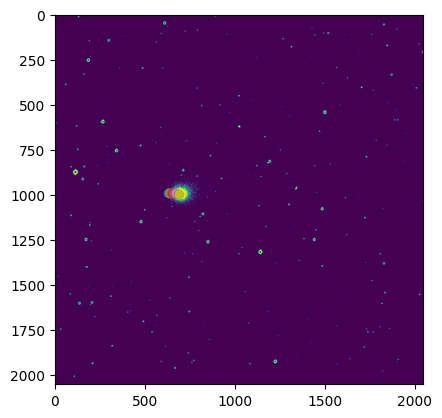

In [31]:
vStackedImage, cutoutWcs = StackImages(vReducedDataPaths, "V", dayInt, roughPos, 1550, cropOffset, removeStars=True)

Text(0, 0.5, 'Arbitrary Y')

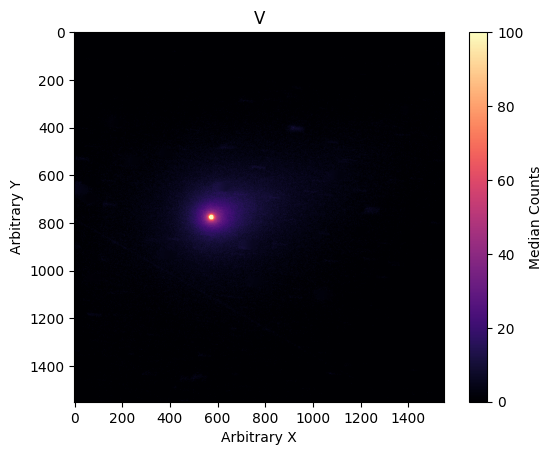

In [32]:
plt.imshow(vStackedImage, cmap="magma", vmin=0, vmax=100)
plt.colorbar(label="Median Counts")
plt.title("V")
plt.xlabel("Arbitrary X")
plt.ylabel("Arbitrary Y")

#plt.ylim(1000, 600)
#plt.xlim(400, 800)

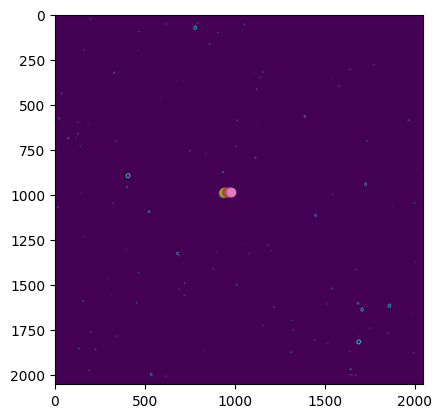

In [15]:
rStackedImage, _ = StackImages(rReducedDataPaths, "R", dayInt, roughPos, 1550, cropOffset, removeStars=True)

Text(0, 0.5, 'Arbitrary Y')

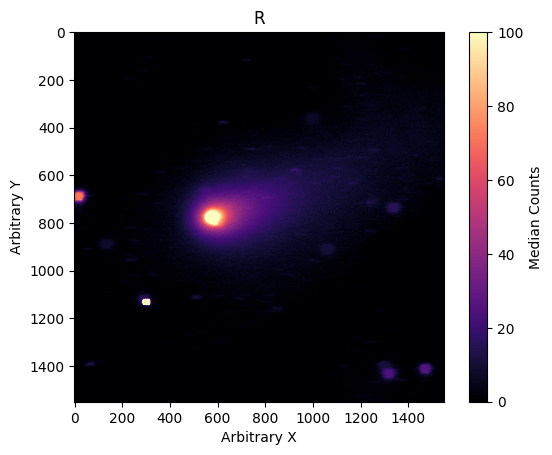

In [16]:
plt.imshow(rStackedImage, cmap="magma", vmin=0, vmax=100)
plt.colorbar(label="Median Counts")
plt.title("R")
plt.xlabel("Arbitrary X")
plt.ylabel("Arbitrary Y")

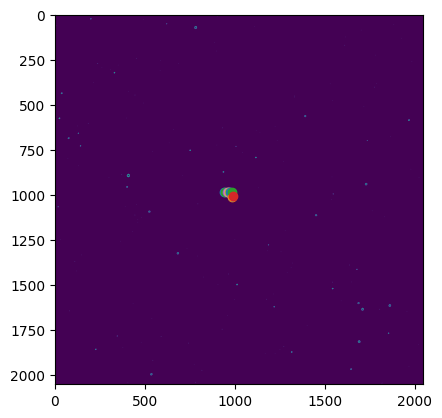

In [17]:
bStackedImage, _ = StackImages(bReducedDataPaths, "B", dayInt, roughPos, 982, cropOffset)

Text(0, 0.5, 'Arbitrary Y')

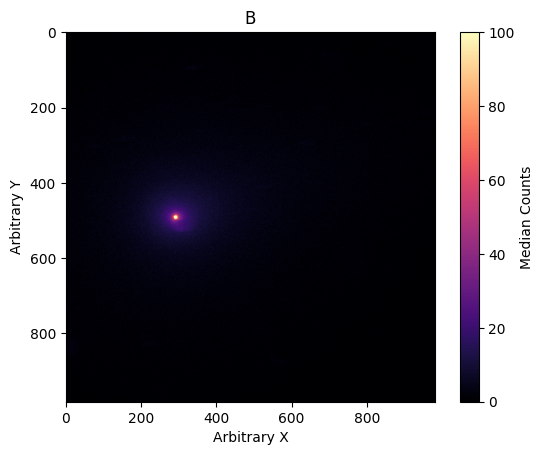

In [18]:
plt.imshow(bStackedImage, cmap="magma", vmin=0, vmax=100)
plt.colorbar(label="Median Counts")
plt.title("B")
plt.xlabel("Arbitrary X")
plt.ylabel("Arbitrary Y")

In [19]:
ctk.SaveFits(vStackedImage, f"../DataProducts/StackedImages/{day}/vStacked.fits")
ctk.SaveFits(rStackedImage, f"../DataProducts/StackedImages/{day}/rStacked.fits")
ctk.SaveFits(bStackedImage, f"../DataProducts/StackedImages/{day}/bStacked.fits")

1110.58978755313
1110.58978755313
FITS image saved to: ../DataProducts/StackedImages/Day12/vStacked.fits
1971.728627101346
1971.728627101346
FITS image saved to: ../DataProducts/StackedImages/Day12/rStacked.fits
296.78459967011247
296.78459967011247
FITS image saved to: ../DataProducts/StackedImages/Day12/bStacked.fits


##### Automated Stack

  0%|          | 0/4 [00:00<?, ?it/s]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]


 25%|██▌       | 1/4 [01:12<03:36, 72.27s/it]

1110.58978755313
1110.58978755313
FITS image saved to: ../DataProducts/StackedImages/Day12/vStacked.fits
1971.728627101346
1971.728627101346
FITS image saved to: ../DataProducts/StackedImages/Day12/rStacked.fits
296.78459967011247
296.78459967011247
FITS image saved to: ../DataProducts/StackedImages/Day12/bStacked.fits


 50%|█████     | 2/4 [01:50<01:44, 52.46s/it]

779.9404022193922
779.9404022193922
FITS image saved to: ../DataProducts/StackedImages/Day13/vStacked.fits
1377.5927701139476
1377.5927701139476
FITS image saved to: ../DataProducts/StackedImages/Day13/rStacked.fits
184.57930220509738
184.57930220509738
FITS image saved to: ../DataProducts/StackedImages/Day13/bStacked.fits


 75%|███████▌  | 3/4 [03:00<01:00, 60.29s/it]

1020.0574446196788
1020.0574446196788
FITS image saved to: ../DataProducts/StackedImages/Day14/vStacked.fits
1866.011903957509
1866.011903957509
FITS image saved to: ../DataProducts/StackedImages/Day14/rStacked.fits
260.8253840422974
260.8253840422974
FITS image saved to: ../DataProducts/StackedImages/Day14/bStacked.fits


100%|██████████| 4/4 [04:41<00:00, 70.36s/it]

612.3357103675261
612.3357103675261
FITS image saved to: ../DataProducts/StackedImages/Day17/vStacked.fits
992.1023275328178
992.1023275328178
FITS image saved to: ../DataProducts/StackedImages/Day17/rStacked.fits
127.97480166928989
127.97480166928989
FITS image saved to: ../DataProducts/StackedImages/Day17/bStacked.fits


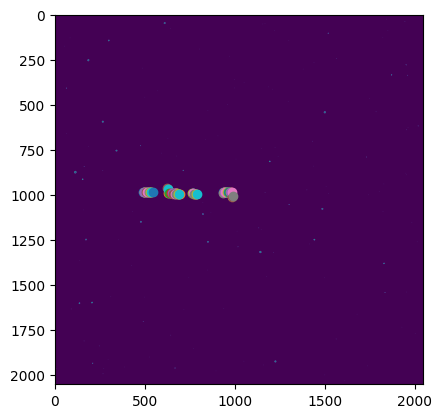

In [33]:
from tqdm import tqdm

days = ["Day12", "Day13", "Day14", "Day17"]

for day in tqdm(days):
    match day:
        case "Day12":
            wcs = WCS(fits.open("../../Data/wcs/day12.fits")[0].header)
            dayInt = 0

            roughPos=(980, 980)
            cropOffset=[+200, 0]

            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

        case "Day13":
            wcs = WCS(fits.open("../../Data/wcs/day13.fits")[0].header)
            dayInt = 1

            roughPos=(750, 1000)
            cropOffset=[+200, 0]

            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-4]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-5]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-6]

        case "Day14":
            wcs = WCS(fits.open("../../Data/wcs/day14.fits")[0].header)
            dayInt = 2

            roughPos=(500, 1000)
            cropOffset=[+300, 0]

            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

        case "Day17":
            wcs = WCS(fits.open("../../Data/wcs/day17.fits")[0].header)
            dayInt = 3

            roughPos=(650, 1000)
            cropOffset=[+200, 0]

            # Note: Excluding last few images due to cloud
            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-3]

    vStackedImage, _ = StackImages(vReducedDataPaths, "V", dayInt, roughPos, 1550, cropOffset)
    rStackedImage, _ = StackImages(rReducedDataPaths, "R", dayInt, roughPos, 1550, cropOffset)
    bStackedImage, _ = StackImages(bReducedDataPaths, "B", dayInt, roughPos, 1550, cropOffset)

    ctk.SaveFits(vStackedImage, f"../DataProducts/StackedImages/{day}/vStacked.fits")
    ctk.SaveFits(rStackedImage, f"../DataProducts/StackedImages/{day}/rStacked.fits")
    ctk.SaveFits(bStackedImage, f"../DataProducts/StackedImages/{day}/bStacked.fits")